In [420]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba import jit
from tqdm import tqdm

%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.figsize'] = [8, 6]
from scipy.stats import norm
from IPython.display import clear_output

In [421]:
L = 1
xmin, xmax = -L, L
res = 2048
x_arr = np.linspace(xmin, xmax, res)
dx = (x_arr[1]-x_arr[0])
N = res

kmax = np.pi/dx
kmin = 2*np.pi/L
k_pos = np.arange(0, kmax, kmin)
k_neg = np.arange(-kmax, 0, kmin)
k_arr = np.concatenate([k_pos, k_neg])

In [422]:
sig = L/100
offset = 0.5
omega = 50.0

psi_initial = np.sqrt(norm.pdf(x_arr, loc=offset, scale=sig))

In [7]:
dx*(np.abs(psi_initial)**2).sum(axis=0)

0.9999999999999434

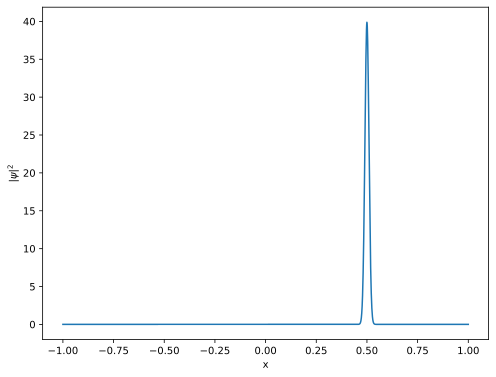

In [8]:
plt.plot(x_arr, np.abs(psi_initial)**2)
plt.xlabel('x')
plt.ylabel('$|ψ|^2$')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.show()

In [9]:
T = 100
dt = 0.1
t_arr  = np.arange(0, T, dt)
s = int(np.ceil(T/dt))

In [10]:
derivmat = np.zeros([N,N], dtype='complex_')
for i in range(N):
    for j in range(N):
        if i!=j:
            derivmat[i,j] = -(2*(np.pi**2)/(N**2 * dx**2))*(-1)**(i-j)/np.sin(np.pi*(i-j)/N)**2
        else:
            derivmat[i,j] = -((np.pi**2)/(3 * dx**2))*(1+2/N**2)

In [11]:
f = np.array([1, -2, 1])

D_laplacian = np.zeros((N,N),dtype='complex_')

for i in range(N):
    
    D_laplacian[i,(i-1)%N] = f[0]
    D_laplacian[i,i] = f[1]
    D_laplacian[i,(i+1)%N] = f[2]
    
D_laplacian[0,:] = 0
D_laplacian[:,0] = 0
D_laplacian[-1,:] = 0
D_laplacian[:,-1] = 0
# D_laplacian[0,0]  = -1
# D_laplacian[-1,-1]= -1
D_laplacian *= (1/dx**2)

In [12]:
dx**2*D_laplacian

array([[ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -2.+0.j,  1.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j, -2.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       ...,
       [ 0.+0.j,  0.+0.j,  0.+0.j, ..., -2.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  1.+0.j, -2.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j]])

In [13]:
# Compile with jit for faster matmul. WARNING: Jit is extremely temperamental
@jit(nopython=True)
def matrix_deriv(u_arr, derivmat):
    return derivmat@u_arr

@jit(nopython=True)
def V_potential(x, ω):
    return (1/2)*(ω**2)*(x**2)

@jit(nopython=True)
def propagate(u_arr, derivmat, x, ω):
    return 1j*(matrix_deriv(u_arr, derivmat)/2 - V_potential(x, ω)*u_arr)



In [14]:
psi_array = np.zeros((t_arr.shape[0] + 1, psi_initial.shape[0]), dtype='complex_')

psi_array[0] = psi_initial

In [15]:
(np.abs(psi_initial)**2).sum()*dx

0.9999999999999434

In [16]:
psi_array.shape

(1001, 2048)

In [13]:

for i, t in enumerate(t_arr):
    # f1 = propagate( psi_array[i]          , derivmat, x_arr, omega)
    # f2 = propagate( psi_array[i] + f1*dt/2, derivmat, x_arr, omega)
    # f3 = propagate( psi_array[i] + f2*dt/2, derivmat, x_arr, omega)
    # f4 = propagate( psi_array[i] + f3*dt  , derivmat, x_arr, omega)  
    # #psi_array[i+1] = psi_array[i] + (dt/6)*(f1 + 2*f2 + 2*f3 + f4)
    # next_state = psi_array[i] + (dt/6)*(f1 + 2*f2 + 2*f3 + f4)
    
    next_state = psi_array[i] + dt*propagate(psi_array[i], D_laplacian, x_arr, omega)
    
    normalization = np.sqrt((np.abs(next_state)**2).sum()*dx)
    psi_array[i+1] = next_state/normalization
    
    mean = (dx*x_arr*np.abs(next_state/normalization)**2).sum()
    
    print(f'{i+1}/{t_arr.shape[0]}, t = {t:.2f}, norm = {normalization:.2f}, mean = {mean:.2f}')
    clear_output(wait=True)

1000/1000, t = 99.90, norm = 209485.81, mean = 0.50


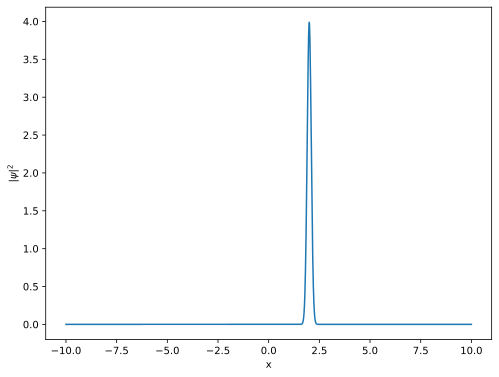

In [518]:
plt.plot(x_arr, np.abs(psi_initial)**2)
plt.xlabel('x')
plt.ylabel('$|ψ|^2$')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.show()

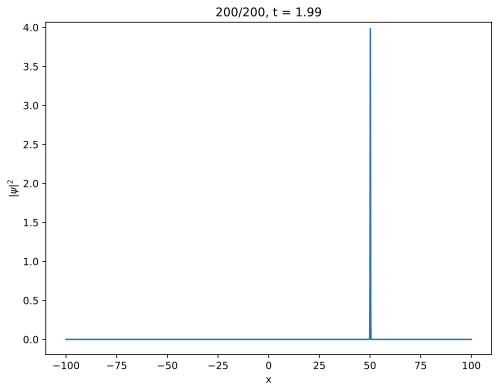

In [296]:

for i, t in enumerate(t_arr):
    
    fig, ax = plt.subplots(1)
    
    psi = psi_array[i]
    prob = np.abs(psi)**2
    
    ax.plot(x_arr, prob)
    
    ax.set_title(f'{i+1}/{t_arr.shape[0]}, t = {t:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('$|ψ|^2$')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    plt.show()
    clear_output(wait=True)

In [297]:
psi_array

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

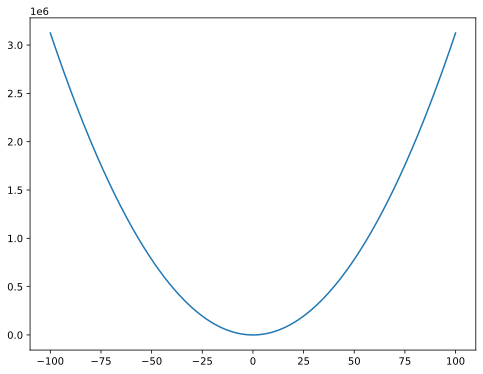

In [284]:
plt.plot(x_arr, (1/2)*omega**2*x_arr**2)

In [391]:
H = -(1/2)*D_laplacian+ np.diag((1/2)*(omega**2)*(x_arr**2))

In [392]:
eig_vals, eig_vecs = np.linalg.eig(H)

In [393]:
eig_vals.shape, eig_vecs.shape

((2048,), (2048, 2048))

In [396]:
np.abs(eig_vals).max(), np.abs(eig_vals).min(), np.linalg.det(eig_vecs)

/Users/jeremywelsh/anaconda3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/jeremywelsh/anaconda3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


(3125105.204689578, 12.310639066159132, (0.999998821115741+0j))

In [397]:
U_t = np.exp(-1j*np.outer(t_arr, eig_vals))
U_t.shape

(100, 2048)

In [398]:
psi_eig = np.linalg.inv(eig_vecs)@(psi_initial)
psi_eig.shape

(2048,)

In [399]:
psi_eig_t = np.multiply(U_t, psi_eig)

psi_eig_t.shape

(100, 2048)

In [80]:
psi_arr_t = (eig_vecs@psi_eig_t.T).T


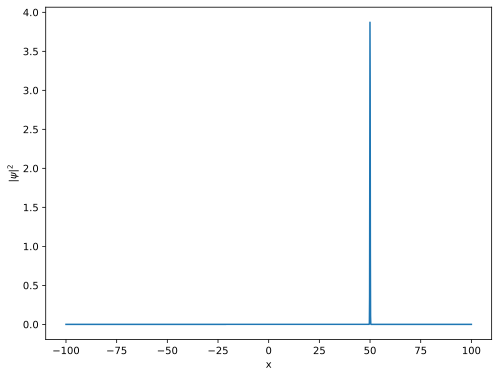

In [400]:
plt.plot(x_arr, np.abs(psi_initial)**2)
plt.xlabel('x')
plt.ylabel('$|ψ|^2$')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.show()

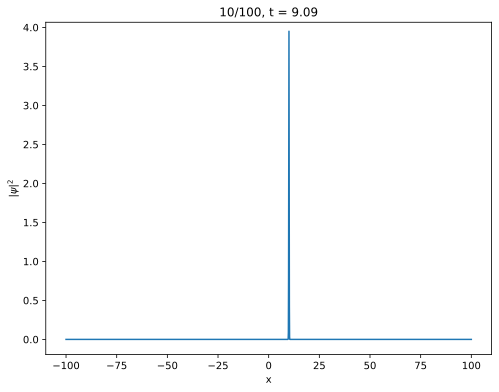

In [401]:
for i, t in enumerate(t_arr[::10]):
    
    fig, ax = plt.subplots(1)
    
    psi = psi_arr_t[i]
    prob = np.abs(psi)**2
    
    ax.plot(x_arr, prob)
    
    ax.set_title(f'{i+1}/{t_arr.shape[0]}, t = {t:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('$|ψ|^2$')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    plt.show()
    clear_output(wait=True)

In [402]:
D_e, D_v = np.linalg.eig(D_laplacian)

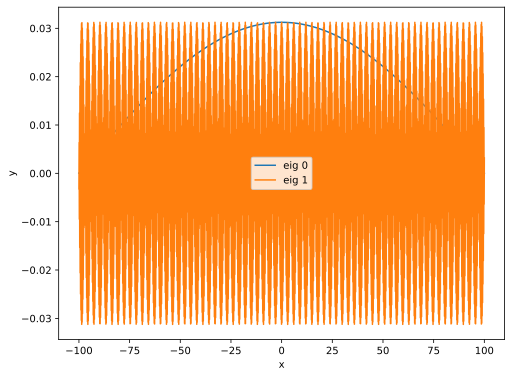

In [405]:
epsi = 0
for i in range(2):
    
    ydata = (np.real(D_v)[:,i]).ravel() # + epsi

    xdata = x_arr #[np.argsort(ydata)]
    
    #plt.scatter(xdata, ydata, s=1.0,label=f'eig {i}') #, linestyle='-', alpha=0.1)
    plt.plot(xdata, ydata,label=f'eig {i}') 
    #epsi += 0.001
    
# plt.plot(x_arr,ydata.max()*np.sin(np.pi*x_arr/L), c='r', label='goop')
# plt.plot(x_arr,ydata.max()*np.cos(np.pi*x_arr/L), c='k', label='goop')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [241]:
(np.real(D_v)[:,4]).ravel()[0:10]

array([-0.03125   ,  0.03078993, -0.02942325,  0.02719022, -0.02415658,
        0.02041165, -0.01606571,  0.01124672, -0.00609657,  0.00076691])

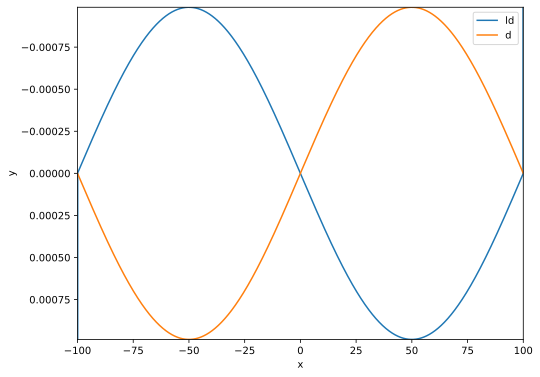

In [408]:
A = -((np.pi/L))**2
#plt.plot( x_arr, np.real(derivmat@(np.sin(np.pi*x_arr/L))), label='md')
plt.plot( x_arr, -np.real(D_laplacian@(np.sin(np.pi*x_arr/L))), label='ld')
plt.plot(x_arr, A*np.sin(np.pi*x_arr/L), label='d')
plt.legend()

plt.xlabel('x')
plt.ylabel('y')

plt.xlim(-L,L)
plt.ylim(-A, A)
plt.show()

In [460]:
quartic_eps = 1.0
omega = 1

V_x = (1/2)*omega**2*x_arr**24

V_shift = 0

V_pert = quartic_eps*( norm.pdf(x_arr, loc=-0.5, scale=0.001) + norm.pdf(x_arr, loc=0.5, scale=0.001))



Hamiltonian_QHO = - (1/2)*D_laplacian + np.diag(V_x + V_pert)
Hamiltonian_QHO.shape

(2048, 2048)

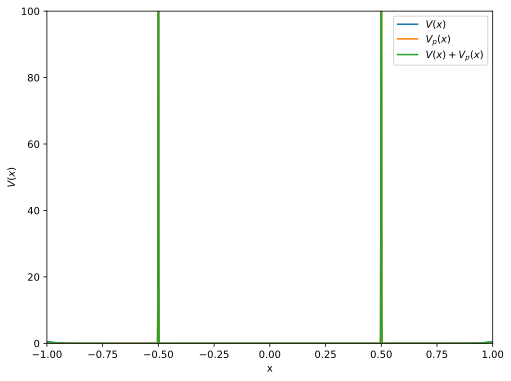

In [461]:
xdata = x_arr
ydata0 = V_x
ydata1 = V_pert
plt.plot(xdata, ydata0, label=f'$V(x)$')
plt.plot(xdata, ydata1, label=f'$V_p(x)$')
plt.plot(xdata, ydata0 + ydata1, label=f'$V(x) + V_p(x)$')
plt.legend()
plt.xlabel('x')
plt.ylabel('$V(x)$')
plt.xlim(-L, L)
plt.ylim(0,100)
plt.savefig(f'QHO_eigenstates.png')
plt.show()

In [464]:
QHO_eig_vals_unsorted, QHO_eig_vecs_unsorted = np.linalg.eig(Hamiltonian_QHO)
QHO_eig_vals_unsorted.shape, QHO_eig_vecs_unsorted.shape

((2048,), (2048, 2048))

In [465]:
np.imag(QHO_eig_vals_unsorted).sum()

0.0

In [466]:
sort_index = np.argsort(np.abs(QHO_eig_vals_unsorted))

QHO_eig_vals = np.real(QHO_eig_vals_unsorted)[sort_index]
QHO_eig_vecs = QHO_eig_vecs_unsorted[:,sort_index]

In [467]:
np.linalg.det(QHO_eig_vecs)

/Users/jeremywelsh/anaconda3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/jeremywelsh/anaconda3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


(1.0000000000005058+0j)

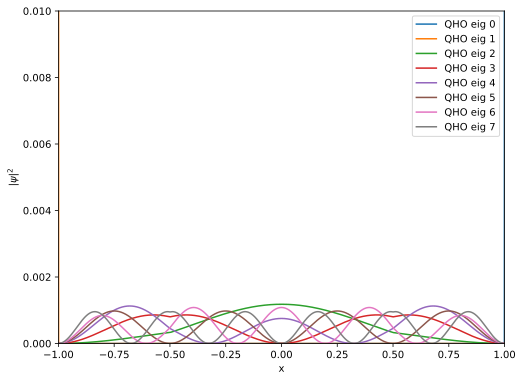

In [468]:
n_e = 8

for i in range(n_e):
    
    xdata = x_arr
    ydata = (np.abs(QHO_eig_vecs[:,i])**2).ravel()
    
    plt.plot(xdata, ydata, label=f'QHO eig {i}')
    
plt.legend()
plt.xlabel('x')
plt.ylabel('$|ψ|^2$')
plt.xlim(-L, L)
plt.ylim(0,0.01)
plt.savefig(f'QHO_eigenstates.png')
plt.show()

In [469]:
psi_arr = np.zeros((t_arr.shape[0], N),dtype='complex_')
psi_arr.shape

(100, 2048)

In [470]:
# weights_i = np.random.randn(N)
# weights_i[10:] = 0.0

# psi_initial_unnormalized = QHO_eig_vecs@weights_i # [:,0] + b*QHO_eig_vecs[:,1]

# norm_i = np.sqrt((dx*np.abs(psi_initial_unnormalized)**2).sum())

# psi_initial = psi_initial_unnormalized/norm_i

In [483]:
sig = L/100
offset = 0 #.75

psi_gaussian = np.sqrt(norm.pdf(x_arr, loc=offset, scale=sig))

# Project psi_gaussian onto first 20 QHO eigenstates:
# Qv @ weights = psi_gaussian
# Qv.T @ Qv @ weights = Qv.T @ psi_gaussian
# weights = pinv(Qv.T @ Qv) @ Qv.T @ psi_gaussian

N_states = 25

M = QHO_eig_vecs[:,0:N_states]

weights = np.linalg.pinv(M.T @ M) @ M.T @ psi_gaussian

psi_initial_unnormalized = M@weights

norm_i = np.sqrt((dx*np.abs(psi_initial_unnormalized)**2).sum())

psi_initial = psi_initial_unnormalized/norm_i

In [484]:
(dx*np.abs(psi_initial)**2).sum()

1.0

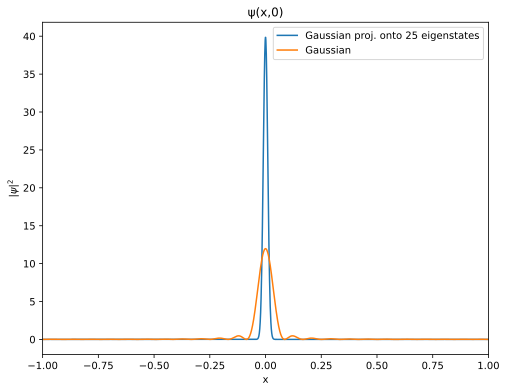

In [485]:
xdata = x_arr
ydata = np.abs(psi_initial)**2
    
plt.plot(xdata, np.abs(psi_gaussian)**2, label=f'Gaussian proj. onto {N_states} eigenstates')
plt.plot(xdata, ydata, label=f'Gaussian')
    
plt.legend()
plt.xlabel('x')
plt.ylabel('$|ψ|^2$')
plt.xlim(-L, L)
#plt.ylim(0,15)
plt.title(f'ψ(x,0)')
plt.savefig(f'QHO_initial.png')
plt.show()

In [486]:
T = 1
dt = 0.01
t_arr  = np.arange(0, T, dt)

E_n = np.real(QHO_eig_vals)
psi_n = QHO_eig_vecs


psi_n_inv = psi_n.T
psi_initial_n = psi_n_inv@psi_initial

psi_arr_n = np.zeros((t_arr.shape[0] + 1, N),dtype='complex_')

psi_arr_n[0] = psi_initial_n

for i, t in enumerate(t_arr):
    
    #print(f'{i+1} / {t_arr.shape[0]}')
    #clear_output(wait=True)
    
    psi_arr_n[i + 1] = np.exp(-1j*dt*E_n)*psi_arr_n[i] #initial_n

In [487]:
psi_arr = (psi_n@psi_arr_n.T).T
psi_arr.shape

(101, 2048)

In [488]:
(dx*np.abs(psi_arr)**2).sum(axis=-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [489]:
omega*(np.arange(0,10) + 1/2)

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

In [490]:
QHO_eig_vals[0:10]

array([ 0.5       ,  0.5       ,  2.05887306,  6.74919116, 12.07348347,
       19.74297658, 31.83517501, 46.39328268, 61.45430298, 78.96599829])

In [491]:
x_expectation = (dx*x_arr*np.abs(psi_arr)**2).sum(axis=-1)
p_expectation = (-dx*np.conj(psi_arr)*1j*np.gradient(psi_arr,axis=-1)).sum(axis=-1)
v_expectation = np.gradient(x_expectation, axis=0)

In [492]:
x_expectation.shape, p_expectation.shape, v_expectation.shape

((101,), (101,), (101,))

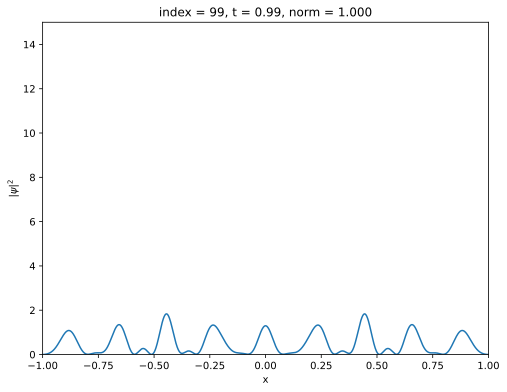

In [493]:
for i,t in enumerate(t_arr[0:]):
    xdata = x_arr
    ydata = np.abs(psi_arr[i])**2
    
    norm_i = ydata.sum()*dx
    
    
    plt.plot(x_arr, ydata)
    #plt.legend()

    plt.xlabel('x')
    plt.ylabel('$|ψ|^2$')
    
    plt.title(f'index = {i}, t = {t:.2f}, norm = {norm_i:.3f}')

    plt.xlim(-L,L)
    plt.ylim(0,15)

    plt.savefig(f'plots/qho_{i:03d}.jpg')
    plt.show()
    clear_output(wait=True)

In [482]:
e_initial = (dx*(np.conj(psi_initial).T@Hamiltonian_QHO@psi_initial))
e_initial

(4.548526049181579+0j)

In [407]:
e_arr = np.zeros_like(t_arr, dtype='complex_')
for i,t in enumerate(t_arr):
    e = (dx*(np.conj(psi_arr[i]).T@Hamiltonian_QHO@psi_arr[i]))
    e_arr[i] = e

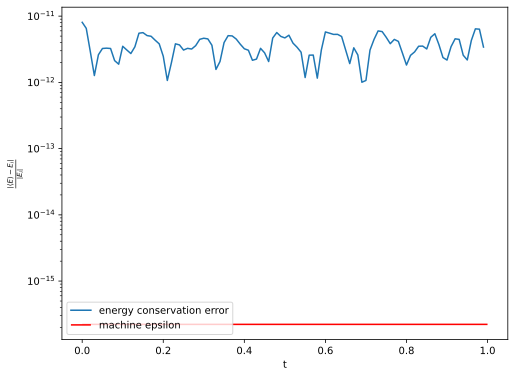

In [408]:
e_err = np.abs( e_arr - e_initial )/np.abs(e_initial)
plt.plot(t_arr, e_err, label='energy conservation error')
plt.hlines(np.finfo(float).eps, 0, T, color='r', label='machine epsilon')
plt.xlabel('t')
plt.ylabel(r'$ \frac{ \left| \langle E \rangle - E_i \right| }{ \left| E_i \right| }$')
plt.legend()
plt.yscale('log')
plt.show()

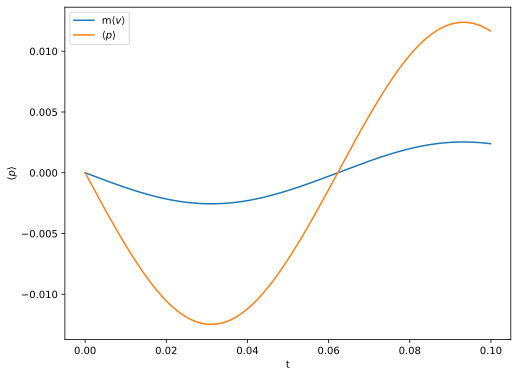

In [461]:
plt.plot(t_arr, v_expectation[0:-1], label=r'm$\langle v \rangle $')
plt.plot(t_arr, np.real(p_expectation[0:-1]), label=r'$\langle p \rangle $')
plt.xlabel('t')
plt.ylabel(r'$\langle p \rangle $')
plt.legend()
plt.show()

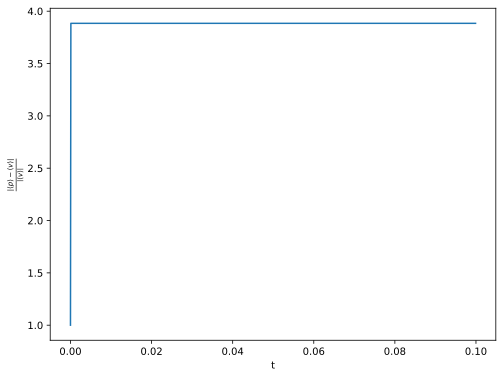

In [462]:
p_err = np.abs(p_expectation[0:-1] - v_expectation[0:-1])/np.abs(v_expectation[0:-1])

plt.plot(t_arr, p_err)
plt.xlabel('t')
plt.ylabel(r'$ \frac{ \left| \langle p \rangle - \langle v \rangle \right| }{ \left|\langle v \rangle \right| }$')
plt.show()

In [409]:
np.abs(p_expectation[0:-1] - v_expectation[0:-1]).mean()

0.0003514396824076658

In [410]:
np.abs( e_arr - e_initial ).mean()

2.1505646241917956e-09